<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/Lab_8_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings

In this lab we will use an embedding to train a simple model over the IMDB dataset, but we will use an embedding instead of a one-hot representation. For this, we will use the fastText embeddings that have been provided.

First, let's start by importing the data and the packages that we will use. Remember to set the runtime environment to GPU!

## Data Import

In [0]:
# General imports
import string
import numpy as np
import pandas as pd
import sklearn.feature_extraction as skprep
from sklearn.metrics import roc_curve, auc
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(20190124)
%matplotlib inline

# Keras imports
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, MaxPooling1D
from keras.layers import Activation
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# Download a zip file with the data
!wget --no-check-certificate --output-document=IMDB.zip 'https://drive.google.com/uc?export=download&id=1owCcH4eU_XvUzrjnMVec-obX3endPzy_'

# Extract the files.
!unzip IMDB.zip

--2019-03-27 13:06:03--  https://drive.google.com/uc?export=download&id=1owCcH4eU_XvUzrjnMVec-obX3endPzy_
Resolving drive.google.com (drive.google.com)... 172.217.212.100, 172.217.212.139, 172.217.212.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.212.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tcm4cqbg59rtm7n6e3lbqm1k2na0drqr/1553688000000/07563968753594904197/*/1owCcH4eU_XvUzrjnMVec-obX3endPzy_?e=download [following]
--2019-03-27 13:06:09--  https://doc-04-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tcm4cqbg59rtm7n6e3lbqm1k2na0drqr/1553688000000/07563968753594904197/*/1owCcH4eU_XvUzrjnMVec-obX3endPzy_?e=download
Resolving doc-04-68-docs.googleusercontent.com (doc-04-68-docs.googleusercontent.com)... 172.217.212.132, 2607:f8b0:4001:c03::84
Connecting to doc-04-68-docs.googleusercontent.com (d

With this we are ready to start training embeddings!

# fasttext

We will use [fasttext embeddings](https://github.com/facebookresearch/fastText) in this lab. For this, we need to download the fasttext model and apply it to our data, i.e., associate each word with the corresponding embedding vector.

fasttext is a heavy program, so it makes sense to use the C++ library directly. This does complicate our life a bit, but nothing a few lines of code can't solve. First, we will download the library and unzip it as before.



In [0]:
!wget https://github.com/facebookresearch/fastText/archive/v0.2.0.zip
  
!unzip v0.2.0.zip

--2019-03-27 13:06:18--  https://github.com/facebookresearch/fastText/archive/v0.2.0.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.2.0 [following]
--2019-03-27 13:06:18--  https://codeload.github.com/facebookresearch/fastText/zip/v0.2.0
Resolving codeload.github.com (codeload.github.com)... 192.30.253.120, 192.30.253.121
Connecting to codeload.github.com (codeload.github.com)|192.30.253.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.2.0.zip’

v0.2.0.zip              [  <=>               ]   4.10M  15.4MB/s    in 0.3s    

2019-03-27 13:06:19 (15.4 MB/s) - ‘v0.2.0.zip’ saved [4304799]

Archive:  v0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-

Now we need to [compile](https://en.wikipedia.org/wiki/Compiler) the library. Compiling turns the code we just downloaded to something the computer can understand. Configuring this is complicated, so programmers add a [makefile](http://www.cs.colby.edu/maxwell/courses/tutorials/maketutor/) with instructions for the compiler. This means we just need to call the command ```make``` in the base folder with the code. This code does it:

In [0]:
%cd fastText-0.2.0

!make

/content/fastText-0.2.0
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/args.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/dictionary.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/productquantizer.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/matrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/qmatrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/vector.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/model.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/utils.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/meter.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/fasttext.cc
src/fasttext.cc: In member function ‘void fasttext::FastText::quantize(const fasttext::Args&)’:
src/fasttext.cc:302:45: warning: ‘std::vector<int> fasttext::FastText::selectEmbeddings(int32_t) const’ is deprecated: selectEmb

There are some warnings, but we can ignore them as they are for future versions.

Now, we need to download the embedding vectors. These are **really heavy downloads** of about 8GB.  fasttext is a language-dependent model, so be sure to download the one for your chosen application. The list is [here](https://fasttext.cc/docs/en/english-vectors.html). There are four levels of embeddings:

- Vectors trained over Wikipedia (1 million words, 16 billion tokens).
- Vectors trained over Wikipedia with subword information.
- Vectors trained over a webcrawl of many websites ([Common Crawl](http://commoncrawl.org/)). This one has 2M words and 200B tokens.
- Vectors trained over a webcrawl of many websites with subword information. 

For the lab we will use the first one, but I encourage you to use try other ones! The download will take a little while.

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
  
!gunzip -v -f cc.en.300.bin.gz

--2019-03-27 13:07:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  35.3MB/s    in 2m 17s  

2019-03-27 13:09:27 (31.3 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]

cc.en.300.bin.gz:	 37.8% -- replaced with cc.en.300.bin


Now we are ready to go!

## Data Preprocessing

With this ready we can now start working on the data, which comes from the [Internet Movie Database](https://www.imdb.com/) (IMDB). The following code reads the data in the format it comes, which is the folder 'IMDB_Lecture_Sample' with two folders: pos and neg with positive and negative reviews. 


In [0]:
# Come back to the original work folder
%cd /content

/content


In [0]:
# Import relevant packages
import os
import codecs
import pandas as pd

# List all files in the "pos" directory. Replace with your own!
dir = 'IMDB_Lecture_Sample/train/pos/'
fileList = os.listdir(dir)

# Create vector with texts
outtexts = []

# Read the files in the directory and append them with the class to the dataset
for eachFile in fileList:
    with codecs.open(dir + eachFile, encoding='utf-8') as _fp:
        fileData = _fp.read()
        outtexts.append(fileData)
    _fp.close()
    
# Create dataframe from outputs
texts = pd.DataFrame({'texts': outtexts, 'class': 1})

# Repeat for negative values
# List all files in the "pos" directory
dir = 'IMDB_Lecture_Sample/train/neg/'
fileList = os.listdir(dir)

# Create vector with texts
outtexts = []

# Read the files in the directory and append them with the class to the dataset
for eachFile in fileList:
    with codecs.open(dir + eachFile, encoding='utf-8') as _fp:
        fileData = _fp.read()
        outtexts.append(fileData)
    _fp.close()
    
# Create dataframe from outputs
texts = pd.concat((texts, pd.DataFrame({'texts': outtexts, 'class': 0})), ignore_index = True)

texts.describe()

,class
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


Now we'll clean the text, getting rid of special characters and keeping the text in a clear form. 

In [0]:
# Text cleaning
import string

# Collect punctiation signs.
table = str.maketrans(' ', ' ', string.punctuation)

# Remove them from the text
texts.iloc[:,1] = [j.translate(table) for j in texts.iloc[:,1]]
texts.iloc[:,1] = [j.replace('\x96',' ') for j in texts.iloc[:,1]]

# Eliminate double spaces
texts.iloc[:,1] = [" ".join(j.split()) for j in texts.iloc[:,1]]

# Show first 5
texts.head()

,class,texts
0,1,I really enjoyed the reunion a lot I would hav...
1,1,I wanted to see Valentine ever since I saw tha...
2,1,My children just happened to stop at this movi...
3,1,Katherine Heigl Marley Shelton Denise Richards...
4,1,Turned out to be a classy production with what...


## Estimating the embedding

Once we have the embedding model, using it consists of:

1. Calculate the words that appear on the text and save to disk
2. Use the fastText program to obtain the word embeddings.
3. Import the embeddings into a Keras input layer.
4. Train the model!

First, we will start by selecting the individual words. The Keras internal model "[Tokenizer](https://keras.io/preprocessing/text/#tokenizer)" will allow us to quickly do this, with the added benefit of giving us a [dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) of the words, which will be stored in the "tokenizer" model.

A dictionary is a very powerful object included by Python, which will efficiently index anything by any key. In our case it will index the words and an arbitraty number that will give its position. Read the linked article to know more about dictionaries, but it is important that you understand its usefulness: It allows fast (indexed) access to objects linked by a key (in this case, the words).

In [0]:
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(texts.iloc[:,1]) # Trains it over the tokens that we have.

# Get words
Vals = list(tokenizer.word_index.keys())

# Write CSV with the output.
file = codecs.open('IMDBWords.csv', "w", "utf-8")

for item in Vals:
    file.write("%s\r\n" % item)
    
file.close()

In [0]:
!ls

fastText-0.2.0	     IMDBWords.csv  sample_data
IMDB_Lecture_Sample  IMDB.zip	    v0.2.0.zip


In [0]:
!head IMDBWords.csv

the
and
a
of
to
is
in
it
i
this


We now have a csv file with all the words being used to review the movies in a standard format. Let's get the embeddings!

We need to call the fasttext software from the command line.

In [0]:
!ls

fastText-0.2.0	     IMDBWords.csv  sample_data
IMDB_Lecture_Sample  IMDB.zip	    v0.2.0.zip


In [0]:
!./fastText-0.2.0/fasttext print-sentence-vectors fastText-0.2.0/cc.en.300.bin < IMDBWords.csv > EmbeddingIMDB.tsv

tcmalloc: large alloc 4800004096 bytes == 0x55f496ce4000 @  0x7fc13da73887 0x55f48413feef 0x55f484150734 0x55f4841511c7 0x55f48415e253 0x55f4841283c8 0x7fc13cb10b97 0x55f48412845a
tcmalloc: large alloc 2400002048 bytes == 0x55f5b4e88000 @  0x7fc13da73887 0x55f48413feef 0x55f4841504c4 0x55f4841511c7 0x55f48415e253 0x55f4841283c8 0x7fc13cb10b97 0x55f48412845a


As always, ignore the warnings. They are basically saying "I need a very large amount of RAM to do what you are asking!".

This process actually takes a relatively long time. Let's take a look at the command part by part:

- ```!./fastText-0.2.0/fasttext``` invokes fasttext. The notation "./" means "execute this program".

- We give it two parameters ```print-sentence-vectors``` which instruct fastText to actually give us the embedding for every word, and ```fastText-0.2.0/cc.en.300.bin``` which is the language model we are using.

- Then comes the processing of the inputs and outputs. The "```< IMDBWords.csv```" is telling Linux "give IMDBWords.csv as an input to what's to the left" and the "```> EmbeddingIMDB.tsv```" is telling Linux "write whatever is outputted from the left into EmbeddingIMDB.tsv".

The output is a space-separated file with the embedding vectors in the same order we gave them to the software.

In [0]:
!head EmbeddingIMDB.tsv

-0.040902 0.058467 -0.010321 0.035355 -0.027129 0.016771 0.0054634 -0.012907 -0.014288 -0.0015782 -0.080665 0.0046677 0.020279 -0.0020526 -0.046287 -0.029847 0.012894 0.011567 -0.006924 -0.013908 -0.0067564 -0.0061605 -0.014448 0.0069548 0.0010292 -0.07417 0.010987 0.011773 -0.031122 -0.023272 0.0074486 -0.019942 -0.0082534 -0.17495 -0.01807 -0.0070631 -0.025471 0.064953 0.00166 0.02227 0.0056682 -0.0072136 -0.027801 -0.014074 -0.055771 0.049818 -0.007309 -0.017649 -0.0044152 0.040688 -0.024261 0.034503 -0.0086712 -0.043835 0.0070655 -0.053175 0.008306 0.045381 0.0078419 -0.022345 0.037185 0.0041834 0.0024069 0.00056557 0.035013 0.0054505 -0.026406 0.0071596 -0.0059939 0.0052182 0.072519 0.024593 0.042916 0.02227 -0.015782 -0.026384 0.0041797 0.028758 0.1778 0.073325 -0.0096955 0.0067667 -0.047348 0.053457 0.031812 0.00092231 0.036672 -0.034541 0.0046972 0.072503 -0.032606 -0.011956 -0.018245 0.0075088 0.046505 0.022023 0.051143 -0.044863 -0.010241 0.037496 0.02796 -0.0095708 -0.006060

Note that this is only for training, for testing we would:

- If we kept the embedding as is, we simply calculate the new embeddings for the new words and add it to our matrix.

- If we retrained the embeddings, then we would either use the output that we already have if the word was in our original vocabulary, or just leave a vector of zeros for those words if it is not.

fastText outputs space-separated words. We replace them with a comma.

In [0]:
import fileinput

with fileinput.FileInput('EmbeddingIMDB.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')

We add a first line with the variable names, to be able to import it back.

In [0]:
import numpy as np
import os

# Create the first line
firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'

# Open as read only. Read the file
with open('EmbeddingIMDB.tsv', 'r') as original: 
  data = original.read()

# Open to write and write the first line and the rest
with open('EmbeddingsIMDB.csv', 'w') as modified: 
  modified.write(firstLine + data)

In [0]:
!head EmbeddingsIMDB.csv

D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D110,D111,D112,D113,D114,D115,D116,D117,D118,D119,D120,D121,D122,D123,D124,D125,D126,D127,D128,D129,D130,D131,D132,D133,D134,D135,D136,D137,D138,D139,D140,D141,D142,D143,D144,D145,D146,D147,D148,D149,D150,D151,D152,D153,D154,D155,D156,D157,D158,D159,D160,D161,D162,D163,D164,D165,D166,D167,D168,D169,D170,D171,D172,D173,D174,D175,D176,D177,D178,D179,D180,D181,D182,D183,D184,D185,D186,D187,D188,D189,D190,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200,D201,D202,D203,D204,D205,D206,D207,D208,D209,D210,D211,D212,D213,D214,D215,D216,D217,D218,D219,D220,D221,D22

Just what we wanted! Now we have a matrix with every word in the document with its corresponding Embedding. We can now import this file into Python, and use it to train our model.

## Using the Embedding Layer

The next step is to actually train a neural network with an Embedding Layer. For this, Keras has the aptly named "Embedding" layer, which will take care of our structures. The following code creates a very simple network that does the following:

1. Read the embeddings.
2. Calculate the One-Hot inputs (by using an "index") which will index which words are in which text.
3. Create a layer that associates the indexes with the embeddings.
4. Create the rest of the architecture.
5. Train the model.

In [0]:
# Read word embeddings
Embeddings = pd.read_csv('EmbeddingsIMDB.csv', sep=',', decimal = '.', 
                         low_memory = True, index_col = False)
Embeddings.describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D291,D292,D293,D294,D295,D296,D297,D298,D299,D300
count,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,...,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000,18184.000000
mean,-0.008114,0.001208,-0.002125,0.061677,-0.013451,-0.015525,0.011203,-0.010970,-0.003307,0.007139,...,0.012734,-0.004633,-0.065000,0.018106,0.007834,0.002493,-0.003404,0.059532,-0.002828,-0.006115
std,0.053542,0.054069,0.056607,0.053417,0.058679,0.060263,0.056204,0.051736,0.053164,0.052639,...,0.062315,0.054321,0.063343,0.057616,0.052185,0.052340,0.050751,0.058838,0.057073,0.057053
min,-0.238420,-0.258440,-0.234590,-0.209000,-0.269920,-0.252730,-0.241330,-0.225070,-0.253600,-0.192840,...,-0.286190,-0.260210,-0.372480,-0.216090,-0.205250,-0.231730,-0.195230,-0.182810,-0.218960,-0.242250
25%,-0.043690,-0.032514,-0.039860,0.029557,-0.051336,-0.054479,-0.025823,-0.044332,-0.038836,-0.027946,...,-0.029086,-0.040105,-0.091571,-0.021151,-0.027146,-0.031749,-0.036911,0.025306,-0.040889,-0.043635
50%,-0.008481,0.001711,-0.002530,0.056534,-0.012240,-0.015622,0.011373,-0.011645,-0.004031,0.006403,...,0.010355,-0.003896,-0.056295,0.016616,0.008979,0.002177,-0.002744,0.065219,-0.002057,-0.006468
75%,0.027115,0.035524,0.035258,0.089126,0.026632,0.025418,0.048343,0.022532,0.030916,0.041714,...,0.052027,0.032257,-0.025976,0.055056,0.043000,0.036707,0.029690,0.093998,0.035636,0.031268
max,0.206840,0.262040,0.275430,0.451850,0.216590,0.198930,0.260180,0.194320,0.218730,0.255010,...,0.315650,0.210360,0.208360,0.240600,0.189180,0.243320,0.193750,0.460820,0.261510,0.217310


We will now create a dictionary for the embeddings. The zip function allows to create the (key, element) structure that we need. Read more about the zip function [here](https://docs.python.org/3.7/library/functions.html#zip). 

In [0]:
# Create embedding dictionary

EmbeddingsDict = dict(zip(Vals, Embeddings.values))

Now, let's study our texts to create the optimal embedding layer. One of the decisions we need to make is what is going to be the maximum size of our documents. Too large, and we will need to add a lot of padding thus will make it inefficient; too small, and we will be losing a lot of information. There is no clear rule here, I usually try to cover 90% of all elements, but you can argue anything that makes sense to you.

Avg. no of words: 215.74
Std. deviation: 164.93
Max words: 1011


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


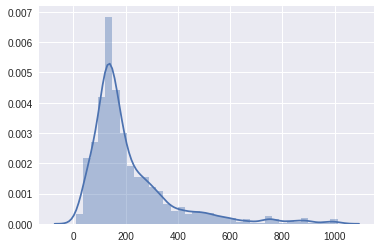

In [0]:
import seaborn as sns
import numpy as np
%matplotlib inline

# Count maximum number of words per file.
wordDist = [len(w.split()) for w in texts.iloc[:,1]]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))

# Generate the plot
distIMDB = sns.distplot(wordDist)

# I'm saving the image to a PDF, as it makes it easier later to download.
distIMDB.figure.savefig("wordDist.pdf", format = "pdf")

Arbitrarily, we will use 600 words maximum. Try different values!

Now we create the input layer. The first layer will have the index of each word per-text, which then we will use to efficiently associate with the embedding. For this, we use Keras' "pad_sequence". This will either add padding to texts that are smaller than 600, or trim the ones that are longer. 

In [0]:
# Create word index from input
sequences = tokenizer.texts_to_sequences(texts.iloc[:,1]) # Create the sequences.

# Creates the indexes. Word index is a dictionary with words in it.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Creates the training dataset, adding padding when necessary.
data = pad_sequences(sequences, maxlen=600, 
                     padding = 'post') # add padding at the end. No difference in practice.

# Creates the objective function
labels = texts.iloc[:,0]
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 18184 unique tokens.
Shape of data tensor: (1000, 600)
Shape of label tensor: (1000,)


In [0]:
# Let's save the outputs, so we don't run all of the above 20 times.
# Be efficient! Save always save intermediate outputs

# Create saving directory
!mkdir IMDB_Preprocessed

# Save outputs
np.savetxt("IMDB_Preprocessed/IMDB_Padded.txt", data)
np.savetxt("IMDB_Preprocessed/IMDB_Labels.txt", labels)

In [0]:
data[0]

array([   9,   68,  504,    1, 1222,    3,  171,    9,   56,   24, 2102,
          8,    3,  397,   45,   36,   65,   65, 3350,    2,  121, 2596,
         47,  278,   55,    3,  669,    4,  131,   36,   21,  784,   43,
        155,   36,  130, 4755,    7,    1, 1222,   36,   57,   53,  837,
        102,    2,    9,   98,    8,   13,    3, 1590,   23,    5,  193,
         33, 2310,   40,   63,  670,    4, 8787,   12,  811,    9,   13,
        874,   11, 6127, 2103,    1,  217,  154,    9,   65,   70,  287,
         14,  711,   14,  139,    2,   52,    3,  948,    5,   25,  559,
          5, 1953,    1,  213,  217,    9,  224,   24, 1337,    3,  200,
        711, 6128, 8788,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

As we can see above, our data now is a matrix corresponding to where on the embedding matrix is the vector we are looking for. This is an extremely efficient way of storing embeddings, but uses more CPU. That's ok though!

Now we are almost ready! Now we need to construct the Embedding matrix. This matrix will have the weights associated with each index. Keras will automatically construct the correct embedding of length 600 (see below).

In [0]:
# Create first matrix full with 0's
embedding_matrix = np.zeros((len(word_index) + 1, 300))

# Generate embeddings matrix
for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Print what came out
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.040902  ,  0.058467  , -0.010321  , ...,  0.18736   ,
         0.00035375, -0.0033145 ],
       [ 0.0077348 , -0.0844    ,  0.024902  , ..., -0.010882  ,
        -0.038611  ,  0.034033  ],
       ...,
       [-0.0062131 , -0.063158  , -0.035933  , ...,  0.083236  ,
        -0.033269  , -0.082851  ],
       [-0.022788  , -0.074787  , -0.016591  , ...,  0.066735  ,
         0.022561  ,  0.026505  ],
       [ 0.0096661 , -0.048332  ,  0.0056973 , ...,  0.046023  ,
        -0.028637  , -0.12274   ]])

In [0]:
# Again, we save the intermediate result. If done right you only need this matrix!
# No need to run everything all over again.
np.savetxt("IMDB_Preprocessed/IMDB_EmbeddingMatrix.txt", embedding_matrix)

In [0]:
# We will also save the word dictionary
# A pickle file is a Python native file
import pickle
f = open("IMDB_Preprocessed/WordDictionary.pkl","wb")
pickle.dump(word_index, f)
f.close()

In [0]:
# Zip all files for download.
!zip -r IMDB_Preprocessed.zip IMDB_Preprocessed 

  adding: IMDB_Preprocessed/ (stored 0%)
  adding: IMDB_Preprocessed/IMDB_Labels.txt (deflated 100%)
  adding: IMDB_Preprocessed/IMDB_EmbeddingMatrix.txt (deflated 75%)
  adding: IMDB_Preprocessed/IMDB_Padded.txt (deflated 96%)


In [0]:
# Download files
from google.colab import files
files.download("IMDB_Preprocessed.zip")

## Modelling using an embedding layer

Now that we have this ready, we need to create our model and add an [Embedding Layer](https://keras.io/layers/embeddings/). We'll create a very simple model using Convolutional Layers as hidden layers. In the next lecture we'll check in detail what this means.

In [0]:
# Final model.
model = Sequential()
embedding_layer = Embedding(len(word_index) + 1,           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=600,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model.add(embedding_layer)

Instructions for updating:
Colocations handled automatically by placer.


Very important: If you are letting your embedding to adapt to your own model, you need to set "trainable=True", if not, leave to False.

Done! We have a model that uses an embedding layer as input. Let's try it in a (very bad) model.Our network will take the embedding as input and will estimate the probability of being of class 1 or 0 (positive or negative). A potential architecture is as follows:

- A [1D-Convolutional Layer](https://keras.io/layers/convolutional/): See the next lecture for details :). I will add 64 filters and a kernel size of 3, which means "look for 64 different combinations of 3 words that are useful". We use ReLU activation for it.

- A [Flatten](https://keras.io/layers/core/#flatten) layer: The embedding matrix comes as a, well, a matrix, the output of the first layer will be as well. We need to change this to a shallow 1D tensor. The Flatten layer takes matrices (or N-Dimensional tensors) and turns them into 1D tensors.

- A Dense layer with 64 neurons and ReLU activation.

- A [Dropout](https://keras.io/layers/core/#dropout) layer: Big models can have many millions of parameters. These models are prone to be overfitted. [Srivastava et al. (2014)](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) realized that a simple way to avoid overadjustment was to simply randomly set a large number of parameters to 0. This is called "Dropout". We will randomly set 40% of all weights to 0. This is a tunable parameter, you should experiment with parameters that make sense to you.

- A sigmoid output layer, with 1 neuron. As this is a binary problem, that's the most appropriate one.

In [0]:
# Check for 64 sequences of length 3.
model.add(Conv1D(64, 3, activation = 'relu'))

# Turn output matrices into 1D tensor for shallow network.
model.add(Flatten())

# Add 64 neurons with ReLU activation.
model.add(Dense(64))

# Add dropout.
model.add(Dropout(0.4))
model.add(Activation('relu'))

# Add an output layer with a sigmoid.
model.add(Dense(1))
model.add(Activation('sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


As this is a binary classification problem, we need a binary cross-entropy error function. I will use the optimizer [Adam](https://arxiv.org/abs/1412.6980) by Kingman et al. (2014), which works well for this problem and, more importantly, requires little tuning. 

In [0]:
# Use Adam as optimizer, with a binary_crossentropy error.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Done! Let's see the architecture of our network.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 300)          5455500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 598, 64)           57664     
_________________________________________________________________
flatten_1 (Flatten)          (None, 38272)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2449472   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
__________

The model has around 2.5 million trainable parameters, the rest come from the embedding, which we left unchanged. Quite an increase compared to our last model!

Now we train. We will use 33% of the data as a test set, and train for 10 epochs.

Instructions for updating:
Use tf.cast instead.
Train on 669 samples, validate on 331 samples
Epoch 1/100
669/669 [==============================] - 4s 6ms/step - loss: 0.5943 - acc: 0.7429 - val_loss: 1.0521 - val_acc: 0.0000e+00
Epoch 2/100
669/669 [==============================] - 0s 673us/step - loss: 0.4714 - acc: 0.7593 - val_loss: 1.4867 - val_acc: 0.0030
Epoch 3/100
669/669 [==============================] - 0s 618us/step - loss: 0.3114 - acc: 0.8490 - val_loss: 1.7228 - val_acc: 0.0151
Epoch 4/100
669/669 [==============================] - 0s 609us/step - loss: 0.1560 - acc: 0.9581 - val_loss: 1.2955 - val_acc: 0.2447
Epoch 5/100
669/669 [==============================] - 0s 658us/step - loss: 0.0769 - acc: 0.9865 - val_loss: 3.2470 - val_acc: 0.0302
Epoch 6/100
669/669 [==============================] - 0s 651us/step - loss: 0.0355 - acc: 0.9955 - val_loss: 1.7608 - val_acc: 0.2628
Epoch 7/100
669/669 [==============================] - 0s 666us/step - loss: 0.0177 - acc: 0.9

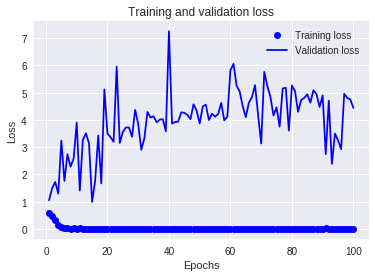

In [0]:
# Fit the model
history = model.fit(data, labels, validation_split=0.33, epochs=100, batch_size=20)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We have clear signs the model overadjusted, particulary after around 50 epochs or so, but this is to be expected in data so simple. That's it! Now we can garnish the power of embeddings for modelling. We just need to learn to create models that can leverage this power. Remember, fastText is available for several hundreds of languages, so they can be used in many contexts.

## Self-study

Change the embedding layer and train your own embeddings. Do you get an improvement?

Try with different architectures to get a better value in the validation layer. Why do you get such low scores? Next lecture we will study architectures that deal correctly with these many inputs.

Compare the convergence speed of Adam with SGD with a reasonable learning rate (try very tiny values). Which one converges faster?

In the coursework you are asked to use more than one embedding. Go through the tutorials for 

- GloVe: Keras has its own tutorial [here](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

- BERT: This one, as is so new, is far more advanced. You need to install a few new packages to make it work. Read [this](https://github.com/hanxiao/bert-as-service).